# spacetrackのテスト その3

長期間の軌道データを調べてみる

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import time
import json
import math
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", 80)

In [3]:
# Hinodeの軌道データをJSON形式でダウンロード (既にダウンロード済みの場合はそれを使う)
norad_cat_id = 29479
file = 'download/tle_{}_all.json'.format(norad_cat_id)
if not os.path.isfile(file):
    print('Downloading new data')
    from spacetrack import SpaceTrackClient
    import spacetrack.operators as op
    import spacetrackaccount
    st = SpaceTrackClient(spacetrackaccount.userid, spacetrackaccount.password)
    data = st.tle(norad_cat_id=norad_cat_id, orderby='epoch', format='json')
    with open(file, 'w') as fp:
        fp.write(data)
    df = pd.read_json(data)
else:
    print('Using pre-existing data')
    df = pd.read_json(file)

Using pre-existing data


In [4]:
# 軌道長半径・近地点高度・遠地点高度 (tle APIの提供するそれぞれの値の精度は 0.001km なので、自分で計算したものと比較してみる)
df['SEMIMAJOR_AXIS2'] = (398600.4418 / (df['MEAN_MOTION'] * 2 * math.pi / (24 * 3600)) ** 2) ** (1/3)
df['APOGEE2'] = (df['SEMIMAJOR_AXIS2'] * (1 + df['ECCENTRICITY']))- 6378.135
df['PERIGEE2'] = (df['SEMIMAJOR_AXIS2'] * (1 - df['ECCENTRICITY']))- 6378.135

In [5]:
# Timestamp型(datetime64[ns])に変換する
# もしgp API を利用した場合は EPOCH にマイクロ秒まで含まれているので、EPOCH_MICROSECONDSを使う必要はない
df['EPOCH2'] = pd.to_datetime(df['EPOCH'] + '.' + df['EPOCH_MICROSECONDS'].map('{:06}'.format))

In [6]:
# EPOCHの時間が遡っているデータが存在する
# tle APIの orderby='epoch' では小数点以下は考慮しないためだと考えられる
dt = df['EPOCH2'].diff()
print(dt[dt < pd.Timedelta(0)].index)

Int64Index([   9,   15,   17,  861,  933,  948, 1062, 1266, 1280, 1544, 1665,
            1683, 1781, 1939, 1993, 2059, 2081, 2594, 3748, 5970],
           dtype='int64')


In [7]:
# EPOCH2でソートする
df = df.sort_values(['EPOCH2', 'FILE']).reset_index(drop=True)

In [8]:
# EPOCHが同じデータが存在する
dt = df['EPOCH2'].diff()
print(dt[dt == pd.Timedelta(0)].index)

Int64Index([ 907, 2134, 2435, 2469, 2621, 2771, 2786, 2788, 2848, 2928, 3012,
            3121, 3536, 5149, 5436, 5715, 5923, 5947, 6054, 6063, 6198, 6252,
            6309, 6323, 6332, 6341, 6358, 6404, 6505, 6522, 6525, 6555, 6616,
            6643, 6742, 6870, 6901, 6936, 6961, 6988, 7021, 7248, 7286, 7531,
            7802, 7836, 7909, 8069, 8079, 8105, 8511, 8514, 8520],
           dtype='int64')


In [9]:
df[2133:2135]

,COMMENT,ORIGINATOR,NORAD_CAT_ID,OBJECT_NAME,OBJECT_TYPE,CLASSIFICATION_TYPE,INTLDES,EPOCH,EPOCH_MICROSECONDS,MEAN_MOTION,ECCENTRICITY,INCLINATION,RA_OF_ASC_NODE,ARG_OF_PERICENTER,MEAN_ANOMALY,EPHEMERIS_TYPE,ELEMENT_SET_NO,REV_AT_EPOCH,BSTAR,MEAN_MOTION_DOT,MEAN_MOTION_DDOT,FILE,TLE_LINE0,TLE_LINE1,TLE_LINE2,OBJECT_ID,OBJECT_NUMBER,SEMIMAJOR_AXIS,PERIOD,APOGEE,PERIGEE,DECAYED,SEMIMAJOR_AXIS2,APOGEE2,PERIGEE2,EPOCH2
2133,GENERATED VIA SPACETRACK.ORG API,18 SPCS,29479,HINODE (SOLAR B),PAYLOAD,U,06041A,2009-12-20 22:05:58,244064,14.629399,0.001564,98.0871,355.778,165.5832,194.5820,0,999,17328,0.000022,6.800000e-07,0.0,816424,0 HINODE (SOLAR B),1 29479U 06041A 09354.92081301 .00000068 00000-0 22395-4 0 9996,2 29479 098.0871 355.7780 0015635 165.5832 194.5820 14.62939852173280,2006-041A,29479,7061.838,98.431,694.745,672.662,0,7061.834374,694.740552,672.658196,2009-12-20 22:05:58.244064
2134,GENERATED VIA SPACETRACK.ORG API,18 SPCS,29479,HINODE (SOLAR B),PAYLOAD,U,06041A,2009-12-20 22:05:58,244064,14.629400,0.001561,98.0870,355.778,165.5767,194.5887,0,999,17328,0.000027,9.100000e-07,0.0,816636,0 HINODE (SOLAR B),1 29479U 06041A 09354.92081301 +.00000091 +00000-0 +27009-4 0 9999,2 29479 098.0870 355.7780 0015615 165.5767 194.5887 14.62939961173288,2006-041A,29479,7061.838,98.431,694.730,672.676,0,7061.834023,694.726077,672.671969,2009-12-20 22:05:58.244064


In [10]:
# EPOCH2が同じデータが複数存在する場合、FILEの大きなデータのみを残すことにする
# ただし、古いデータ(だいたい2004年以前?)はFILEが適当なので、他の方法を検討する必要がある
print(len(df))
df = df[~df.duplicated(subset='EPOCH2', keep='last')]
print(len(df))

8523
8470


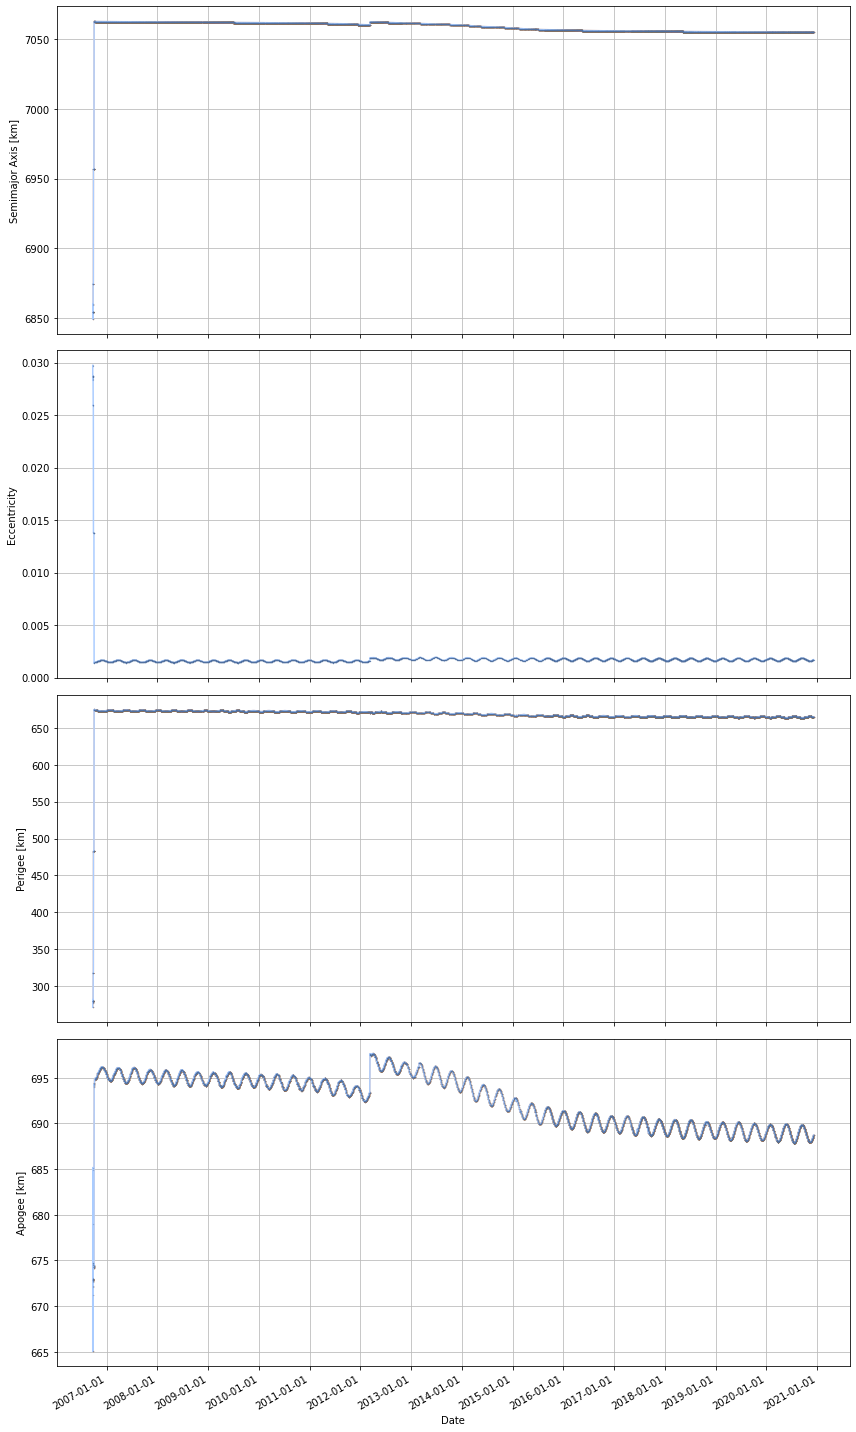

In [11]:
# 軌道長半径、離心率、近地点、遠地点の時間変化をプロット (tle APIが提供する値と、自分で計算したものをプロット)
fig = plt.figure(figsize=(12, 20))
ax1 = fig.add_subplot(4, 1, 1)
ax1.plot(df['EPOCH2'], df['SEMIMAJOR_AXIS2'], color='#ffccaa', marker='.', markersize=1, markeredgecolor='#a07050')
ax1.plot(df['EPOCH2'], df['SEMIMAJOR_AXIS'], color='#aaccff', marker='.', markersize=0.3, markeredgecolor='#5070a0')
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax1.set_xlabel("Date")
ax1.set_ylabel("Semimajor Axis [km]")
ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
ax2 = fig.add_subplot(4, 1, 2)
ax2.plot(df['EPOCH2'], df['ECCENTRICITY'], color='#aaccff', marker='.', markersize=0.3, markeredgecolor='#5070a0')
ax2.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax2.set_xlabel("Date")
ax2.set_ylabel("Eccentricity")
ax2.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
ax3 = fig.add_subplot(4, 1, 3)
ax3.plot(df['EPOCH2'], df['PERIGEE2'], color='#ffccaa', marker='.', markersize=1, markeredgecolor='#a07050')
ax3.plot(df['EPOCH2'], df['PERIGEE'], color='#aaccff', marker='.', markersize=0.3, markeredgecolor='#5070a0')
ax3.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax3.set_xlabel("Date")
ax3.set_ylabel("Perigee [km]")
ax3.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
ax4 = fig.add_subplot(4, 1, 4)
ax4.plot(df['EPOCH2'], df['APOGEE2'], color='#ffccaa', marker='.', markersize=1, markeredgecolor='#a07050')
ax4.plot(df['EPOCH2'], df['APOGEE'], color='#aaccff', marker='.', markersize=0.3, markeredgecolor='#5070a0')
ax4.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax4.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax4.set_xlabel("Date")
ax4.set_ylabel("Apogee [km]")
ax4.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [12]:
# 軌道長半径の時間変化
oneday = pd.Timedelta(days=1)
DT = df['EPOCH2'].diff() / oneday
DSEMIMAJOR_AXIS = df['SEMIMAJOR_AXIS'].diff() / DT
DSEMIMAJOR_AXIS2 = df['SEMIMAJOR_AXIS2'].diff() / DT

In [13]:
DSEMIMAJOR_AXIS.describe()

count      8469.000000
mean        -26.677586
std        7431.685734
min     -534796.064714
25%          -0.002437
50%          -0.001044
75%           0.000000
max      299999.999970
dtype: float64

In [14]:
DSEMIMAJOR_AXIS2.describe()

count      8469.000000
mean        -33.442431
std        7306.091102
min     -532938.021428
25%          -0.002233
50%          -0.000987
75%          -0.000482
max      290928.014510
dtype: float64

In [15]:
(DT * 86400).describe()

count      8469.000000
mean      52928.648922
std       32813.799025
min           0.000863
25%       29506.872672
50%       47279.005344
75%       76833.035136
max      402766.039872
Name: EPOCH2, dtype: float64

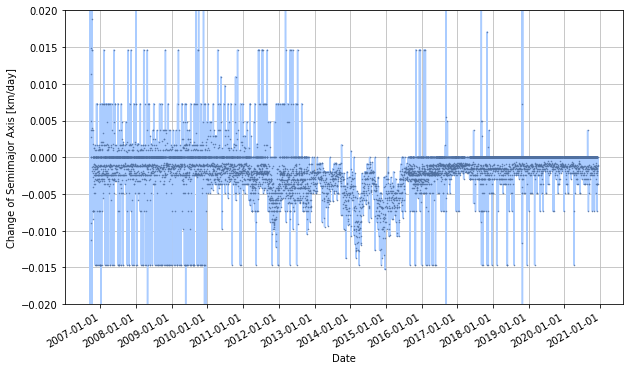

In [16]:
# tle APIが提供する値の精度は 0.001km 
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(df['EPOCH2'], DSEMIMAJOR_AXIS, color='#aaccff', marker='.', markersize=1, markeredgecolor='#5070a0')
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax1.set_xlabel("Date")
ax1.set_ylabel("Change of Semimajor Axis [km/day]")
ax1.set_ylim(-0.02, 0.02)
ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
fig.autofmt_xdate()
plt.show()

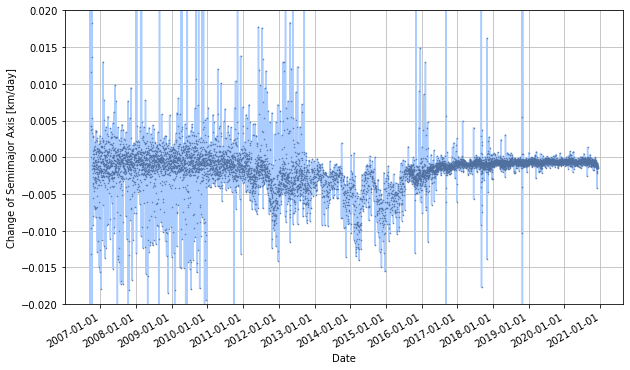

In [17]:
# 自前で計算すると少しよくなる (以下、こちらの値を用いる)
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(df['EPOCH2'], DSEMIMAJOR_AXIS2, color='#aaccff', marker='.', markersize=1, markeredgecolor='#5070a0')
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax1.set_xlabel("Date")
ax1.set_ylabel("Change of Semimajor Axis [km/day]")
ax1.set_ylim(-0.02, 0.02)
ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
fig.autofmt_xdate()
plt.show()

ノイズが多いのでデータをスムージングしてみる

In [18]:
# 1日平均と週平均 (EPOCH2がインデックスになる)
df2 = df.resample('D', on='EPOCH2').mean()
df3 = df.resample('W', on='EPOCH2').mean()
print(len(df), len(df2), len(df3))

8470 5190 742


In [19]:
# 軌道長半径の時間変化
DSEMIMAJOR_AXIS_day = df2['SEMIMAJOR_AXIS2'].diff()
DSEMIMAJOR_AXIS_week = df3['SEMIMAJOR_AXIS2'].diff() / 7.0

In [20]:
DSEMIMAJOR_AXIS_day.describe()

count    4761.000000
mean        0.042631
std         1.780565
min        -0.709359
25%        -0.002288
50%        -0.001014
75%        -0.000550
max       105.554663
Name: SEMIMAJOR_AXIS2, dtype: float64

In [21]:
DSEMIMAJOR_AXIS_week.describe()

count    741.000000
mean       0.038592
std        0.816443
min       -0.011497
25%       -0.002552
50%       -0.000959
75%       -0.000670
max       20.015153
Name: SEMIMAJOR_AXIS2, dtype: float64

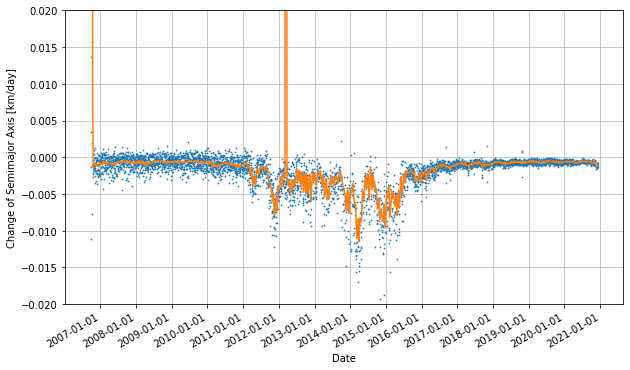

In [22]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(df2.index, DSEMIMAJOR_AXIS_day, '.', markersize=1.5)
ax1.plot(df3.index, DSEMIMAJOR_AXIS_week)
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax1.set_xlabel("Date")
ax1.set_ylabel("Change of Semimajor Axis [km/day]")
ax1.set_ylim(-0.02, 0.02)
ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
fig.autofmt_xdate()
plt.show()

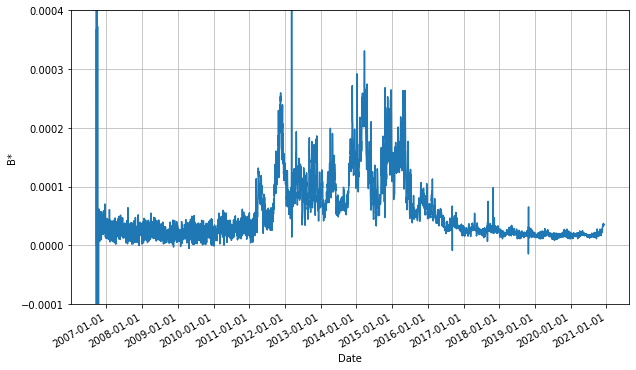

In [23]:
# 抗力項 BSTAR をプロット
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(df['EPOCH2'], df['BSTAR'])
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1, bymonth=1, tz=None))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
ax1.set_xlabel("Date")
ax1.set_ylabel("B*")
ax1.set_ylim(-0.0001, 0.0004)
ax1.grid(b=True, which='major', color='#bbbbbb', linestyle='-')
fig.autofmt_xdate()
plt.show()